In [1]:
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import QuantileTransformer

# This code is for statistic plots

In [2]:
data = pd.read_csv(r"C:\Zhongming Lu\hk_bld\eui\final data\hk_eui_sample_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data = data.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data = data[ (data.highrise_j>0) | (data.podium_j>0) ]
#data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]

In [3]:
data['Area'] = np.where(data['highrise'] == 1, data['highrise_a'], data['podium_are'])

In [4]:
data['retro_before'] = np.where(data['retro']=='Before',1,0)
data['retro_after'] = np.where(data['retro']=='After',1,0)

In [5]:
data.loc[data['Year_Built']<1950,'Year_built_class'] = 1
data.loc[(data['Year_Built']>=1950)&(data['Year_Built']<1960),'Year_built_class']=2
data.loc[(data['Year_Built']>=1960)&(data['Year_Built']<1970),'Year_built_class']=3
data.loc[(data['Year_Built']>=1970)&(data['Year_Built']<1980),'Year_built_class']=4
data.loc[(data['Year_Built']>=1980)&(data['Year_Built']<1990),'Year_built_class']=5
data.loc[(data['Year_Built']>=1990)&(data['Year_Built']<2000),'Year_built_class']=6
data.loc[(data['Year_Built']>=2000)&(data['Year_Built']<2010),'Year_built_class']=7
data.loc[data['Year_Built']>=2010,'Year_built_class']=8

In [6]:
data['log_area'] = np.log10(data['Area']+1)
data['log_hotel_kern'] = np.log10(data['hotel_kern']+1)
data['log_retail_ker'] = np.log10(data['retail_ker']+1)
data['log_parking_ke'] = np.log10(data['parking_ke']+1)
data['log_food_kerne'] = np.log10(data['food_kerne']+1)
data['log_office_ker'] = np.log10(data['office_ker']+1)

In [7]:
data['log_mtr_dist'] = np.log10(data['mtr_dist'])

In [8]:
data['commercial'] = np.where(data['RASTERVALU']==11,1,0)

In [9]:
y = data['kWh_m2_ann']

In [10]:
y.std()/y.mean()

0.9113162292799382

In [11]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']]

In [12]:
data_1 = pd.read_csv(r"C:\Zhongming Lu\hk_bld\bld\hk_commercial_bld\hk_commercial_bld_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
#data_1 = data_1.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
#                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
#                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
#data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data_1 = data_1[ (data_1.highrise_j>0) | (data_1.podium_j>0) ]
#data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]

In [13]:
data_1['Area'] = np.where(data_1['highrise'] == 1, data_1['highrise_a'], data_1['podium_are'])

In [14]:
data_1['retro'] = 0
#data['retro_before'] = np.where(data['retro']=='Before',1,0)
#data['retro_after'] = np.where(data['retro']=='After',1,0)

In [14]:
#data.loc[data['Year_Built']<1950,'Year_built_class'] = 1
#data.loc[(data['Year_Built']>=1950)&(data['Year_Built']<1960),'Year_built_class']=2
#data.loc[(data['Year_Built']>=1960)&(data['Year_Built']<1970),'Year_built_class']=3
#data.loc[(data['Year_Built']>=1970)&(data['Year_Built']<1980),'Year_built_class']=4
#data.loc[(data['Year_Built']>=1980)&(data['Year_Built']<1990),'Year_built_class']=5
#data.loc[(data['Year_Built']>=1990)&(data['Year_Built']<2000),'Year_built_class']=6
#data.loc[(data['Year_Built']>=2000)&(data['Year_Built']<2010),'Year_built_class']=7
#data.loc[data['Year_Built']>=2010,'Year_built_class']=8

In [15]:
data_1['log_area'] = np.log10(data_1['Area']+1)
data_1['log_hotel_kern'] = np.log10(data_1['hotel_kern']+1)
data_1['log_retail_ker'] = np.log10(data_1['retail_ker']+1)
data_1['log_parking_ke'] = np.log10(data_1['parking_ke']+1)
data_1['log_food_kerne'] = np.log10(data_1['food_kerne']+1)
data_1['log_office_ker'] = np.log10(data_1['office_ker']+1)

In [16]:
data_1['log_mtr_dist'] = np.log10(data_1['mtr_dist'])

In [17]:
data_1['commercial'] = np.where(data_1['RASTERVALU']==11,1,0)

In [18]:
X_1 = data_1[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','log_mtr_dist','commercial']]

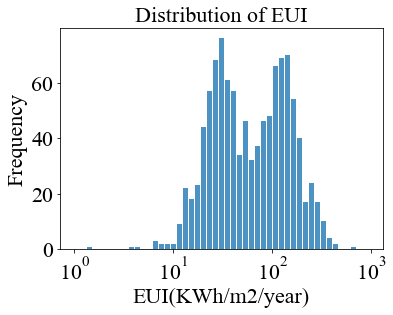

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
mu, sigma = y.mean(), y.std()
bins = np.logspace(np.log10(1),np.log10(y.max()),50) 
plt.hist(y, bins=bins,rwidth=0.8,alpha=0.8)
plt.xscale("log")

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.xaxis.set_major_locator(plt.LogLocator(base=10,numticks=10))

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2, top=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\eui_distribution.png')

plt.show()
plt.close()

In [22]:
log_y = np.log10(y)

In [21]:
log_y_reshape = log_y.to_numpy().reshape(-1,1)

In [47]:
qt = QuantileTransformer(n_quantiles = 20, output_distribution = 'normal', random_state= 8000)
log_y_transform = qt.fit_transform(log_y_reshape)

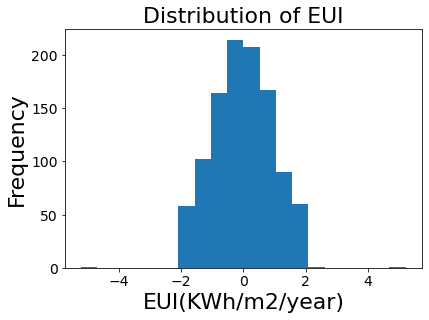

In [48]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(log_y_transform,bins=20)

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

In [19]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams.update({'font.size': 30})

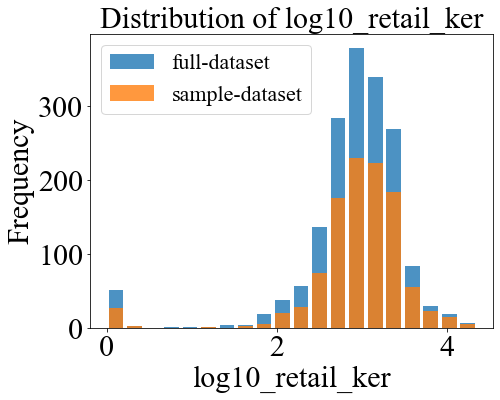

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#mu, sigma = X['log_retail_ker'].mean(), X['log_retail_ker'].std()
#bins = np.logspace(np.log10(1),np.log10(X['retail_ker'].max()),50) 
#plt.hist(X['retail_ker'], bins=bins)
#plt.xscale("log")
plt.hist(X_1['log_retail_ker'],bins=20,alpha=0.8,label="full-dataset",rwidth=0.8)
plt.hist(X['log_retail_ker'],bins=20, alpha=0.8,label="sample-dataset",rwidth=0.8)

ax.set_title("Distribution of log10_retail_ker", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("log10_retail_ker", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper left', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\log_retail_ker.png')

plt.show()
plt.close()

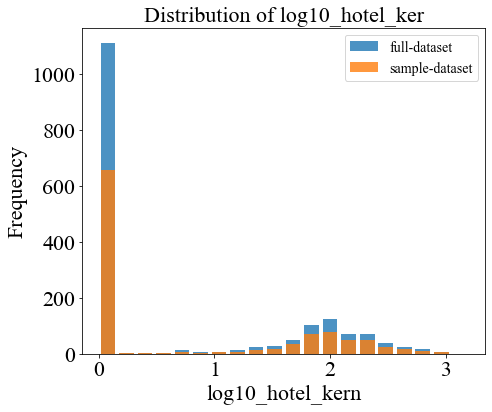

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#mu, sigma = X['log_hotel_kern'].mean(), X['log_hotel_kern'].std()
#bins = np.logspace(np.log10(1),np.log10(X['hotel_kern'].max()),50) 
#plt.hist(X['hotel_kern'], bins=bins)
#plt.xscale("log")
plt.hist(X_1['log_hotel_kern'], bins=20, alpha=0.8,label="full-dataset",rwidth=0.8, range=[0,3.2])
plt.hist(X['log_hotel_kern'], bins=20, alpha=0.8,label="sample-dataset",rwidth=0.8, range=[0,3.2])

ax.set_title("Distribution of log10_hotel_ker", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("log10_hotel_kern", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right', fontsize=14)

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\log_hotel_kern.png')

plt.show()
plt.close()

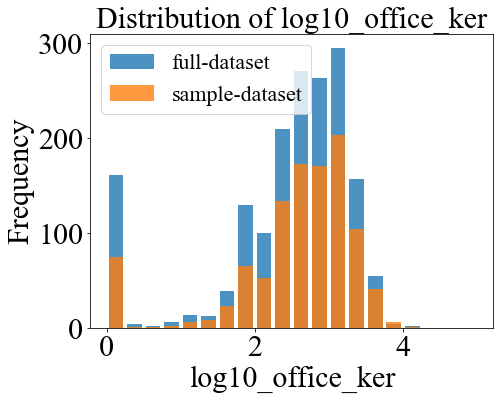

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#mu, sigma = X['log_hotel_kern'].mean(), X['log_hotel_kern'].std()
#bins = np.logspace(np.log10(1),np.log10(X['hotel_kern'].max()),50) 
#plt.hist(X['hotel_kern'], bins=bins)
#plt.xscale("log")
plt.hist(X_1['log_office_ker'], bins=20, alpha=0.8,label="full-dataset",rwidth=0.8, range=[0,5])
plt.hist(X['log_office_ker'], bins=20, alpha=0.8,label="sample-dataset",rwidth=0.8, range=[0,5])

ax.set_title("Distribution of log10_office_ker", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("log10_office_ker", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper left', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\log_office_ker.png')

plt.show()
plt.close()

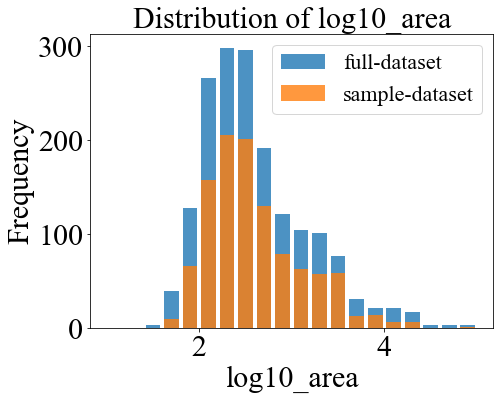

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
mu, sigma = X['log_area'].mean(), X['log_area'].std()
#bins = np.logspace(np.log10(10),np.log10(X['Area'].max()),50) 
#plt.hist(X['Area'], bins=bins)
#plt.xscale("log")
plt.hist(X_1['log_area'], bins=20, alpha=0.8,label="full-dataset",rwidth=0.8, range=[1,5])
plt.hist(X['log_area'], bins=20, alpha=0.8,label="sample-dataset",rwidth=0.8, range=[1,5])

ax.set_title("Distribution of log10_area", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("log10_area", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper right', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\log_area.png')

plt.show()
plt.close()

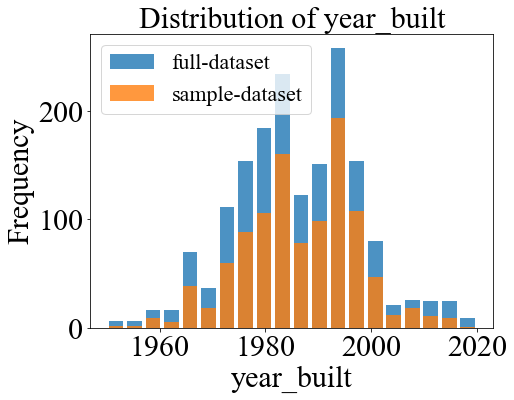

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
mu, sigma = X['Year_Built'].mean(), X['Year_Built'].std()
plt.hist(X_1['Year_Built'], bins=20, alpha=0.8, label="full-dataset", rwidth=0.8, range=[1950,2020])
plt.hist(X['Year_Built'], bins=20, alpha=0.8, label="sample-dataset", rwidth=0.8, range=[1950,2020])

ax.set_title("Distribution of year_built", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("year_built", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper left', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\Year_Built.png')

plt.show()
plt.close()

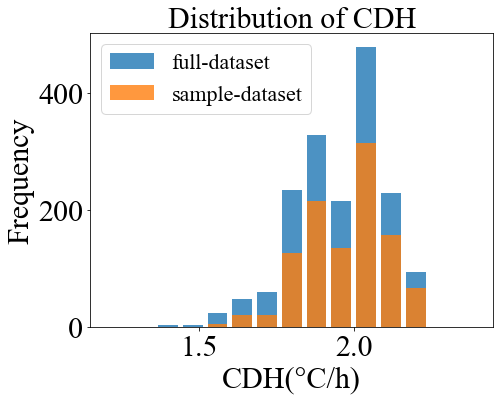

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
mu, sigma = X['tsd_mask'].mean(), X['tsd_mask'].std()


plt.hist(X_1['tsd_mask'], bins=15, alpha=0.8,label="full-dataset",rwidth=0.8, range=[1.2,2.4])
plt.hist(X['tsd_mask'], bins=15, alpha=0.8,label="sample-dataset",rwidth=0.8, range=[1.2,2.4])

ax.set_title("Distribution of CDH", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("CDH(°C/h)", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper left', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\Hourly_Cooling_Degree_Days.png')

plt.show()
plt.close()

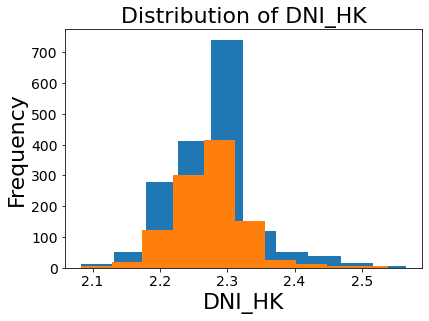

In [40]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
mu, sigma = X['DNI_HK'].mean(), X['DNI_HK'].std()
plt.hist(X_1['DNI_HK'], bins=10)
plt.hist(X['DNI_HK'], bins=10)

ax.set_title("Distribution of DNI_HK", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("DNI_HK", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

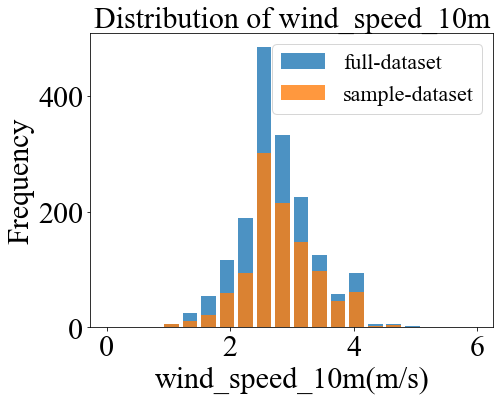

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.hist(X_1['HKG_wind_s'], bins=20, alpha=0.8,label="full-dataset",rwidth=0.8,range=[0,6])
plt.hist(X['HKG_wind_s'], bins=20, alpha=0.8,label="sample-dataset",rwidth=0.8,range=[0,6])

ax.set_title("Distribution of wind_speed_10m", fontsize=30, color='k')
ax.set_ylabel("Frequency", fontsize=30, color='k')
ax.set_xlabel("wind_speed_10m(m/s)", fontsize=30, color='k')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.legend(loc='upper right', fontsize=22)

plt.subplots_adjust(left=0.2,right=0.9,bottom=0.2)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\Surface_wind_speed.png')

plt.show()
plt.close()

#EUI comparison by class

In [86]:
y = data['kWh_m2_ann']

In [87]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','commercial']]

In [88]:
data_set = X.reset_index(drop=True)

In [89]:
log_y=np.log10(y)
log_y_values = log_y.to_list()

In [90]:
data_set['log_eui'] = log_y_values

In [91]:
log_eui_median = data_set['log_eui'].median()
log_eui_median

1.7670816213633223

In [92]:
data_set1 = data_set[data_set['log_eui']<=log_eui_median]
data_set2 = data_set[data_set['log_eui']>log_eui_median]

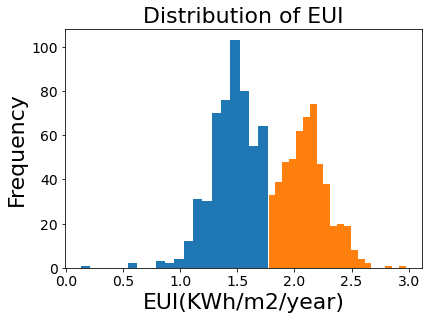

1.4680517914542377
2.1019701362116656


In [93]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['log_eui'],bins=20)
plt.hist(data_set2['log_eui'],bins=20)

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

print (data_set1['log_eui'].median())
print (data_set2['log_eui'].median())

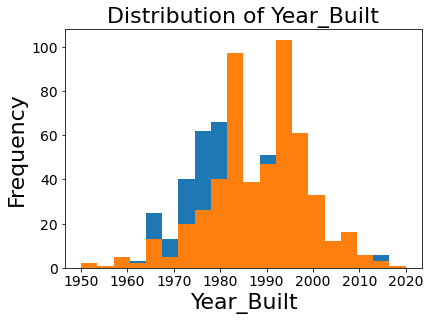

1984.0
1990.0


In [59]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['Year_Built'], bins=20,range=[1950,2020])
plt.hist(data_set2['Year_Built'], bins=20,range=[1950,2020])

ax.set_title("Distribution of Year_Built", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("Year_Built", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

print (data_set1['Year_Built'].median())
print (data_set2['Year_Built'].median())

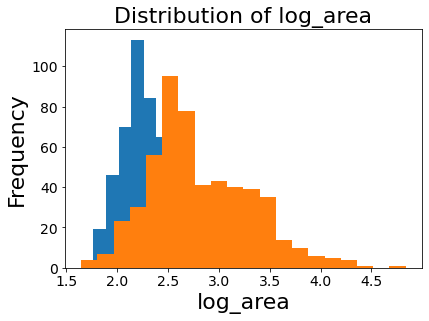

2.290034611362518
2.705434149588279


In [65]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['log_area'], bins=20)
plt.hist(data_set2['log_area'], bins=20)

ax.set_title("Distribution of log_area", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("log_area", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

print (data_set1['log_area'].median())
print (data_set2['log_area'].median())

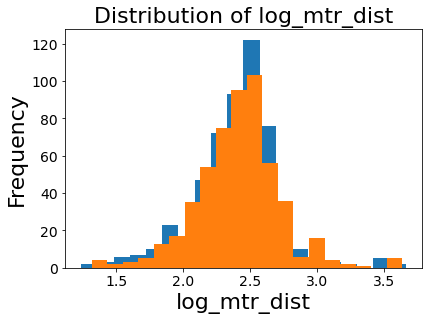

In [51]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['log_mtr_dist'], bins=20)
plt.hist(data_set2['log_mtr_dist'], bins=20)

ax.set_title("Distribution of log_mtr_dist", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("log_mtr_dist", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

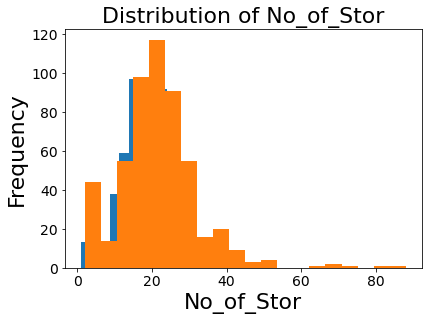

In [100]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))

plt.hist(data_set1['No_of_Stor'], bins=20)
plt.hist(data_set2['No_of_Stor'], bins=20)

ax.set_title("Distribution of No_of_Stor", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("No_of_Stor", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

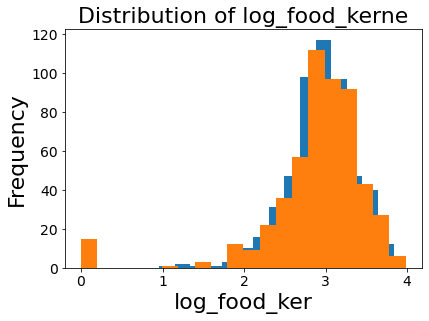

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['log_food_kerne'],bins=20)
plt.hist(data_set2['log_food_kerne'],bins=20)

ax.set_title("Distribution of log_food_kerne", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("log_food_ker", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

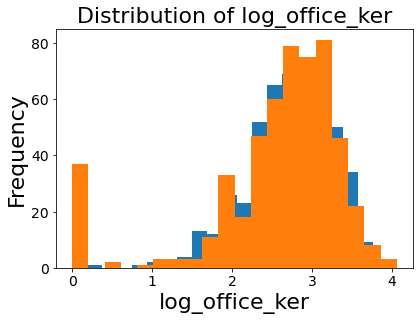

In [53]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['log_office_ker'],bins=20)
plt.hist(data_set2['log_office_ker'],bins=20)

ax.set_title("Distribution of log_office_ker", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("log_office_ker", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

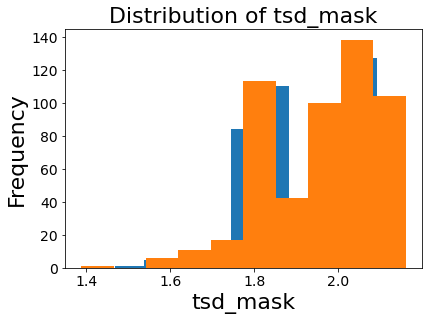

In [50]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(data_set1['tsd_mask'], bins=10)
plt.hist(data_set2['tsd_mask'], bins=10)

ax.set_title("Distribution of tsd_mask", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("tsd_mask", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

# Cross-validation with hyperparameter tuning

In [38]:
data = pd.read_csv(r"C:\Zhongming Lu\hk_bld\eui\final data\hk_eui_sample_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data = data.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data = data[ (data.highrise_j>0) | (data.podium_j>0) ]
data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]
data = data[(data.Year_Built>0) & (data.No_of_Stor>0)]

In [39]:
data['Area'] = np.where(data['highrise'] == 1, data['highrise_a'], data['podium_are'])

In [40]:
data['retro_before'] = np.where(data['retro']=='Before',1,0)
data['retro_after'] = np.where(data['retro']=='After',1,0)

In [41]:
data['log_mtr_dist'] = np.log10(data['mtr_dist'])

In [42]:
data['commercial'] = np.where(data['RASTERVALU']==11,1,0)

In [43]:
data['log_area'] = np.log10(data['Area']+1)
data['log_hotel_kern'] = np.log10(data['hotel_kern']+1)
data['log_retail_ker'] = np.log10(data['retail_ker']+1)
data['log_parking_ke'] = np.log10(data['parking_ke']+1)
data['log_food_kerne'] = np.log10(data['food_kerne']+1)
data['log_office_ker'] = np.log10(data['office_ker']+1)

In [44]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [45]:
log_y = np.log10(y)

In [46]:
log_eui_median = log_y.median()
log_eui_median

1.778729923996112

In [47]:
#log_y_reshape = log_y.to_numpy().reshape(-1,1)

In [48]:
#qt = QuantileTransformer(n_quantiles = 20, output_distribution = 'normal', random_state= 8000)
#log_y_transform = qt.fit_transform(log_y_reshape)

In [49]:
#log_y_transform_s = pd.Series(log_y_transform.flatten())
log_y_category = pd.cut(log_y, bins=5)

In [50]:
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [51]:
#Weight adjustment
for i in range(len(log_y)):
    if log_y[i]<=1.2 or log_y[i]>2.25:
        log_y_weight[i] = log_y_weight[i]*32
    elif log_y[i]>1.70 and log_y[i]<1.90:
        log_y_weight[i] = log_y_weight[i]/16
    else:
        log_y_weight[i] = log_y_weight[i]*6

In [52]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [53]:
data_matrix = xgb.DMatrix(data=X, label=log_y, weight=log_y_weight)

In [54]:
from typing import Tuple
def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    r2_value = r2_score(y, predt)
    return "r2", -r2_value

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [70]:
space = {'max_depth': hp.quniform("max_depth",3,10,1),
        'learning_rate': hp.uniform("learning_rate", 0.1, 2),
        'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
        'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
        'reg_alpha': hp.quniform("reg_alpha", 0, 100,1),
        'reg_lambda': hp.uniform("reg_lambda", 0, 2),
        'subsample': hp.uniform("subsample",0.5, 1), 
        'min_split_loss': hp.uniform("min_split_loss", 0, 9),
        'rate_drop': hp.uniform("rate_drop", 0, 1)}

In [71]:
def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'], 
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'], 
                          'booster': 'dart', 
                          'rate_drop': space['rate_drop'],
                          'objective': 'reg:squarederror' }
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round = 200, seed=8000, feval=r2)

    print ("rmse:", (xgb_cv_result["test-rmse-mean"]).tail(1).iloc[0])
    print ("r2:", (xgb_cv_result["test-r2-mean"]).tail(1).iloc[0])
    return {"loss": (xgb_cv_result["test-r2-mean"]).tail(1).iloc[0], "status": STATUS_OK}

In [21]:
trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

rmse:                                                  
0.44838839999999996                                    
r2:                                                    
-0.1739848                                             
rmse:                                                                    
0.5211932000000001                                                       
r2:                                                                      
-0.030671000000000004                                                    
rmse:                                                                    
0.4431578                                                                
r2:                                                                      
-0.13908179999999998                                                     
rmse:                                                                    
0.45397160000000003                                                      
r2:                                 

rmse:                                                                     
0.4194476                                                                 
r2:                                                                       
-0.2606788                                                                
rmse:                                                                     
0.4558218                                                                 
r2:                                                                       
-0.17770780000000003                                                      
rmse:                                                                     
0.4227654                                                                 
r2:                                                                       
-0.2140064                                                                
rmse:                                                                     
0.4531256                

0.4262388                                                                  
r2:                                                                        
-0.18387360000000003                                                       
rmse:                                                                      
0.4143498                                                                  
r2:                                                                        
-0.25354599999999994                                                       
rmse:                                                                      
0.414306                                                                   
r2:                                                                        
-0.26746060000000005                                                       
rmse:                                                                      
0.419596                                                                   
r2:         

-0.21433960000000002                                                       
rmse:                                                                      
0.418184                                                                   
r2:                                                                        
-0.2636174                                                                 
rmse:                                                                      
0.43907760000000007                                                        
r2:                                                                        
-0.144167                                                                  
rmse:                                                                      
0.41745160000000003                                                        
r2:                                                                        
-0.2295004                                                                 
rmse:       

In [22]:
best_hyperparams

{'colsample_bytree': 0.6305362111999703,
 'learning_rate': 1.9917306879574401,
 'max_depth': 9.0,
 'min_child_weight': 1.0,
 'min_split_loss': 3.113780679835734,
 'rate_drop': 0.7531717570110865,
 'reg_alpha': 0.0,
 'reg_lambda': 0.034959961290293176,
 'subsample': 0.567988025711486}

In [57]:
param_dict_tunning = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': int(best_hyperparams['max_depth']),
              'reg_alpha': best_hyperparams['reg_alpha'],'reg_lambda':best_hyperparams['reg_lambda'],
              'min_child_weight': best_hyperparams['min_child_weight'], 'colsample_bytree': best_hyperparams['colsample_bytree'],
              'learning_rate': best_hyperparams['learning_rate'], 'subsample':best_hyperparams['subsample'],
              'min_split_loss': best_hyperparams['min_split_loss'],'rate_drop':best_hyperparams['rate_drop'],'booster': 'dart'}

In [24]:
xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                       as_pandas=True, num_boost_round = 200, seed=8000, feval=r2)

In [25]:
xgb_cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
0,1.577602,0.025298,1.592077,0.082389,16.131900,0.665380,16.844722,0.864912
1,0.780827,0.443372,0.837749,0.393305,4.471561,5.959372,4.820400,5.535286
2,0.511706,0.228895,0.641122,0.220240,1.261499,1.601105,1.746273,1.569777
3,0.352933,0.129500,0.550617,0.112671,0.057922,0.553469,0.563074,0.541832
4,0.285627,0.059806,0.511456,0.057385,-0.329595,0.178708,0.163498,0.193869
...,...,...,...,...,...,...,...,...
138,0.203598,0.002605,0.422123,0.027255,-0.700739,0.012648,-0.318201,0.033008
139,0.203397,0.002788,0.421424,0.027366,-0.701066,0.012448,-0.319435,0.032654
140,0.203533,0.002700,0.421516,0.027241,-0.700672,0.012183,-0.319662,0.031911
141,0.203701,0.002614,0.421150,0.027213,-0.700982,0.012403,-0.320884,0.031326


# Devlop Cross-validated Model

In [55]:
#best_hyperparams={'colsample_bytree': 0.705034726705756,
# 'learning_rate': 0.5944135119228504,
# 'max_depth': 8.0,
# 'min_child_weight': 11.0,
# 'min_split_loss': 0.36440897415076645,
# 'rate_drop': 0.31335800237105216,
# 'reg_alpha': 0.0,
# 'reg_lambda': 0.00796594673195955,
# 'subsample': 0.6706018165528826}

#best_hyperparams={'colsample_bytree': 0.7776763041485107,
# 'learning_rate': 1.8626801038038336,
# 'max_depth': 4.0,
# 'min_child_weight': 19.0,
# 'min_split_loss': 1.7959166211318665,
# 'rate_drop': 0.14660098709788322,
# 'reg_alpha': 0.0,
# 'reg_lambda': 1.0425250405716064,
# 'subsample': 0.9296612859538033}

#best_hyperparams={'colsample_bytree': 0.7155114323427926,
# 'learning_rate': 0.8171232444207687,
# 'max_depth': 10.0,
# 'min_child_weight': 3.0,
# 'min_split_loss': 2.518389049454657,
# 'rate_drop': 0.496611870387379,
# 'reg_alpha': 3.0,
# 'reg_lambda': 1.2959304362972262,
# 'subsample': 0.7567141297232133}

best_hyperparams={'colsample_bytree': 0.6305362111999703,
 'learning_rate': 1.9917306879574401,
 'max_depth': 9.0,
 'min_child_weight': 1.0,
 'min_split_loss': 3.113780679835734,
 'rate_drop': 0.7531717570110865,
 'reg_alpha': 0.0,
 'reg_lambda': 0.034959961290293176,
 'subsample': 0.567988025711486}

In [58]:
xgb_model = None
for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, log_y):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=log_y.loc[train], weight=log_y_weight[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=log_y.loc[test], weight=log_y_weight[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]
    
    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                              feval=r2, xgb_model=None, verbose_eval=False, early_stopping_rounds=30)
    log_y_pred = xgb_model.predict(test_matrix)
    log_y_true = log_y.loc[test].values
    
    accuracy_num = 0 
    
    for i in range(len(log_y_pred)):
        if log_y_true[i] > log_eui_median:
            if log_y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if log_y_true[i] <= log_eui_median:
            if log_y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = mean_squared_error(log_y.iloc[test], log_y_pred, squared=False)
    r2_test = r2_score(log_y.loc[test],log_y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(log_y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3218
R2: 0.2567
Accuracy:  74.29%
RMSE: 0.3066
R2: 0.3053
Accuracy:  72.86%
RMSE: 0.2904
R2: 0.3899
Accuracy:  76.67%
RMSE: 0.3027
R2: 0.3258
Accuracy:  71.90%
RMSE: 0.2961
R2: 0.2939
Accuracy:  74.64%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

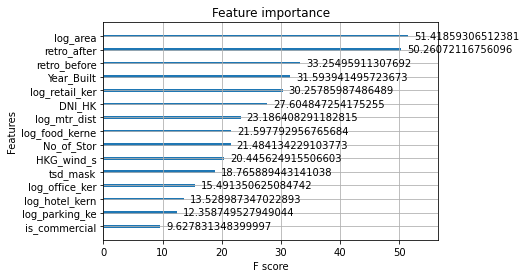

In [24]:
xgb.plot_importance(xgb_model,importance_type ='gain')

In [25]:
data_matrix = xgb.DMatrix(data=X, label=log_y, weight=log_y_weight)

In [30]:
xgb_model_full = xgb.train(params=param_dict_tunning, dtrain=data_matrix, num_boost_round=200, evals=watchlist,
                              feval=r2, xgb_model=xgb_model, verbose_eval=False, early_stopping_rounds=30)

In [24]:
log_y_pred = xgb_model.predict(test_matrix)
#log_y_pred = qt.inverse_transform(log_y_transform_pred.reshape(-1,1))

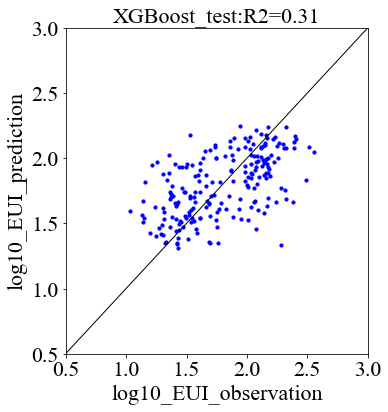

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(log_y.iloc[test], log_y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("XGBoost_test:R2=0.31", fontsize=22)
#ax.annotate('R2=0.31',(1.5,2.5), fontsize=22)
#ax.set_title("%f Error Plot"%(r2_score(log_y.iloc[test],log_y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(mean_squared_error(log_y_transform_s,log_y_transform_pred,squared=False)), fontsize=17)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\XGBoost_test.png')

plt.show()
plt.close()

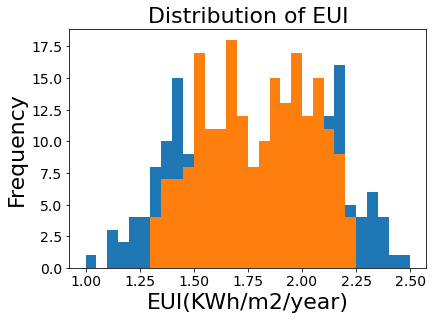

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
#bins = np.logspace(np.log10(1),np.log10(y.max()),50) 
#plt.hist(y, bins=bins)
#log_y_pred = qt.inverse_transform(log_y_transform_pred.reshape(-1,1))
plt.hist(log_y_true,bins=30, range=[1.00,2.50])
plt.hist(log_y_pred,bins=30, range=[1.00,2.50])
#plt.xscale("log")

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

In [139]:
data_output = X
data_output['log_y_pred']=log_y_pred
data_output['log_y_true']=log_y

In [140]:
data_output.to_csv(r'C:\Zhongming Lu\hk_bld\eui\eui_pred_exame.csv',index=False, header=True)

# Shaply Interpretation

In [59]:
import shap

In [60]:
y_pred_shap = xgb_model.predict(data_matrix,pred_contribs=True)

In [66]:
shap_value_dep = y_pred_shap[:,:-1]

In [83]:
abs(shap_value_dep[:,0]).mean()

0.006604832

In [84]:
X_name = ['log10_hotel_ker','log10_parking_ker','log10_food_ker','log10_office_ker','log10_retail_ker',
          'DNI','wind_speed_10m','CDH','log10_area','No_of_Stor','year_built',
          'retro_before_audit','retro_after_audit','log10_mtr_dist','is_commercial_land_use']

In [85]:
X_shap = []

In [87]:
for i in range(len(X_name)):
    X_shap.append(abs(shap_value_dep[:,i]).mean())

In [88]:
X_mean_shap = pd.DataFrame({'X_name':X_name,
                            'X_shap':X_shap})

In [90]:
X_mean_shap.to_csv(r'C:\Zhongming Lu\hk_bld\eui\x_mean_shap_xgb.csv',index=False, header=True)

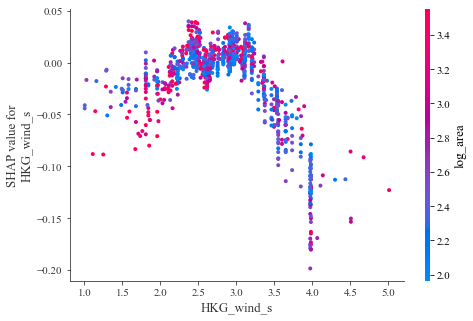

In [47]:
shap.dependence_plot("HKG_wind_s",shap_value_dep, X, interaction_index='log_area')

#Save the model

In [ ]:
#City Commercial Building EUI Map

In [31]:
data_1 = pd.read_csv(r"C:\Zhongming Lu\hk_bld\bld\hk_commercial_bld\hk_commercial_bld_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data_1 = data_1[ (data_1.highrise_j>0) | (data_1.podium_j>0) ]
data_1['Area'] = np.where(data_1['highrise'] == 1, data_1['highrise_a'], data_1['podium_are'])
data_1['retro_before'] = 0
data_1['retro_after'] = 0
data_1['log_area'] = np.log10(data_1['Area']+1)
data_1['log_hotel_kern'] = np.log10(data_1['hotel_kern']+1)
data_1['log_retail_ker'] = np.log10(data_1['retail_ker']+1)
data_1['log_parking_ke'] = np.log10(data_1['parking_ke']+1)
data_1['log_food_kerne'] = np.log10(data_1['food_kerne']+1)
data_1['log_office_ker'] = np.log10(data_1['office_ker']+1)
data_1['log_mtr_dist'] = np.log10(data_1['mtr_dist'])
data_1['commercial'] = np.where(data_1['RASTERVALU']==11,1,0)
data_1['is_commercial'] = data_1['is_commerc']

In [32]:
X_1 = data_1[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']]

In [35]:
X_1_matrix = xgb.DMatrix(data=X_1)

In [36]:
log_y_pred = xgb_model_full.predict(X_1_matrix) 

In [37]:
y_pred = np.power(10, log_y_pred)

In [38]:
data_1['xgb_eui_pred'] = y_pred

In [39]:
data_1.to_csv(r'C:\Zhongming Lu\hk_bld\eui\full_c_bld_eui_pred_xgb.csv',index=False, header=True)

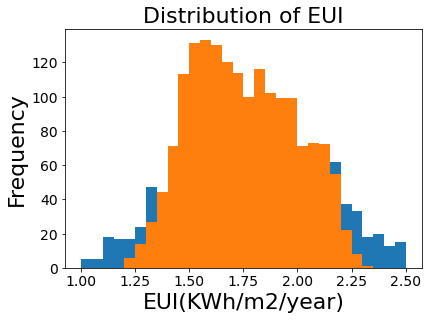

In [40]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))

plt.hist(log_y,bins=30, range=[1.00,2.50])
plt.hist(log_y_pred,bins=30, range=[1.00,2.50])

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()